# Imports and utils

In [82]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import medial_axis

def show(img, title="", cmap='gray', filename=None):
    plt.figure(figsize=(8,6))
    plt.title(title, fontsize=16)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    if filename:
        folder_path = os.path.dirname(filename)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        plt.imsave(filename, img, cmap=cmap)
    plt.show()

def show_with_hist(img, title, cmap='gray', filename=None):
    plt.figure(figsize=(10, 4))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(img.ravel(), bins=256)
    plt.title(title + " — Histogram")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    if filename:
        folder_path = os.path.dirname(filename)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        plt.savefig(filename, img, cmap=cmap)
    plt.show()
    
def grid_images(images, titles, rows, cols, margin=5, bg_color=0, save_path=None, figsize=(10, 6), title_fontsize=14):
    """
    Display a grid of images with titles and optionally save to file.
    """

    assert len(images) == len(titles), "Images and titles list must match!"
    assert len(images) == rows * cols, "rows*cols must equal number of images!"

    # Create matplotlib figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Normalize axes shape (in case of 1 row or 1 col)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    # Fill grid
    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            img = images[idx]

            # Show image
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            ax.set_title(titles[idx], fontsize=title_fontsize)
            ax.axis('off')
            idx += 1

    plt.tight_layout(pad=margin/10)

    # Save if needed
    if save_path:
        folder = os.path.dirname(save_path)
        if folder != "" and not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()



# Load image in greyscale and normalize

In [83]:
gray = cv2.imread('./example/065.jpg', cv2.IMREAD_GRAYSCALE)
gray_norm = gray.astype(np.float32) / 255.0

# Pure sobel

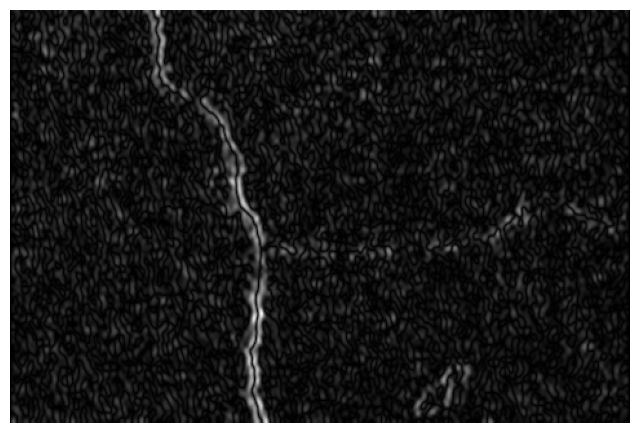

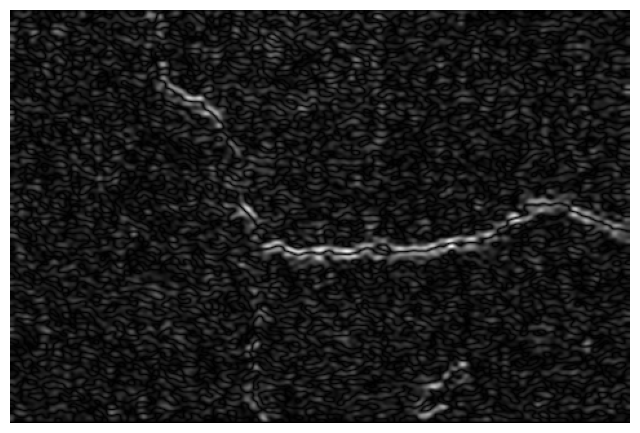

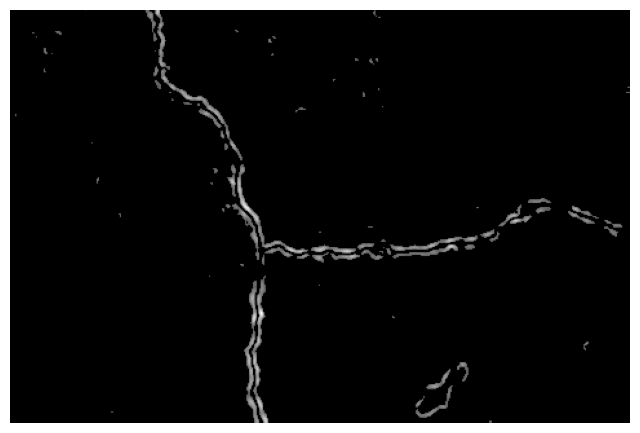

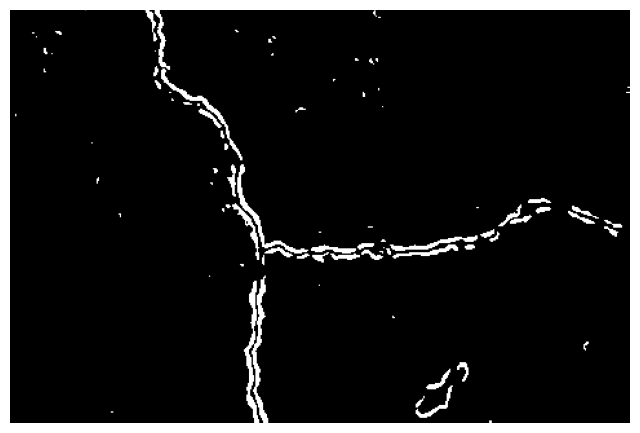

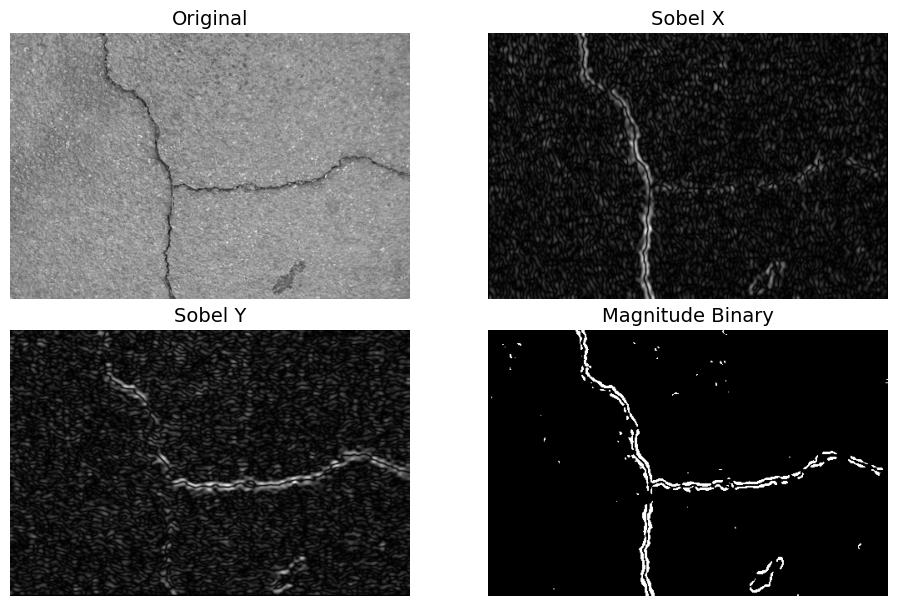

In [84]:
ksize = 15
global_threshold_ratio = 3
sobelx = cv2.Sobel(gray_norm, cv2.CV_64F, 1, 0, ksize=ksize)
sobely = cv2.Sobel(gray_norm, cv2.CV_64F, 0, 1, ksize=ksize)

# Visualization (normalize to 0–255)
sobelx_vis = cv2.normalize(np.abs(sobelx), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
sobely_vis = cv2.normalize(np.abs(sobely), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show(sobelx_vis, filename="./output/sobel_x.png")
show(sobely_vis, filename="./output/sobel_y.png")

mag_raw = np.hypot(sobelx, sobely) # sobelx^2 + sobely^2

# Threshold 
threshold_raw = global_threshold_ratio * np.mean(mag_raw)
mag_raw[mag_raw < threshold_raw] = 0

# Binarize the thresholded magnitude
mag_raw_binary = np.zeros_like(mag_raw, dtype=np.uint8)
mag_raw_binary[mag_raw > 0] = 255

# Visualize the binary mask (optional, for consistency)
mag_raw_vis = cv2.normalize(mag_raw, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
show(mag_raw_vis)
show(mag_raw_binary, filename=f"./output/sobel_only_{ksize}_{global_threshold_ratio}.png")

grid_images([gray,  sobelx_vis, sobely_vis, mag_raw_binary], ["Original", "Sobel X", "Sobel Y", "Magnitude Binary"], 2, 2, bg_color=255, save_path="./output/sobel_comparison.png")


In [85]:
# im1 = cv2.imread('./output/sobel_only_3_3.png', cv2.IMREAD_GRAYSCALE)
# im2 = cv2.imread('./output/sobel_only_15_3.png', cv2.IMREAD_GRAYSCALE)
# im3 = cv2.imread('./output/sobel_only_25_3.png', cv2.IMREAD_GRAYSCALE)
# im4 = cv2.imread('./output/sobel_only_31_3.png', cv2.IMREAD_GRAYSCALE)
# grid_images([im1,  im2, im3, im4], ["k = 3", "k = 15", "k = 25", "k = 31"], 2, 2, bg_color=255, save_path="./output/sobel_mask_comparison.png")

# Sobel + Morphological Operations

## Opening + Closing

### Closing

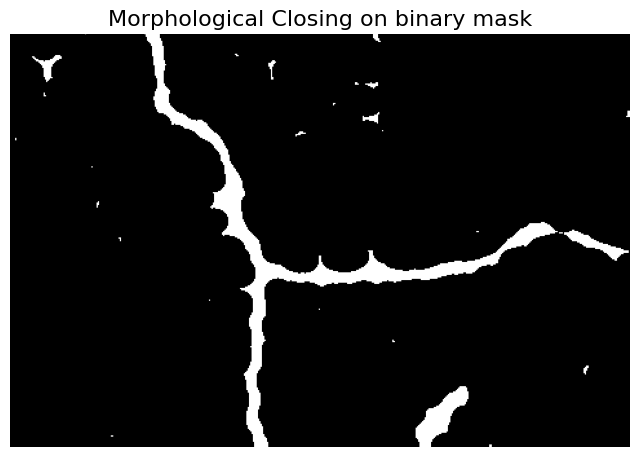

In [86]:
ksize = 21
mag_close = mag_raw_binary.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
mag_close = cv2.morphologyEx(mag_close, cv2.MORPH_CLOSE, kernel_grad)
show(mag_close, "Morphological Closing on binary mask", filename=f"./output/sobel_morph_close_1.png")


### Opening

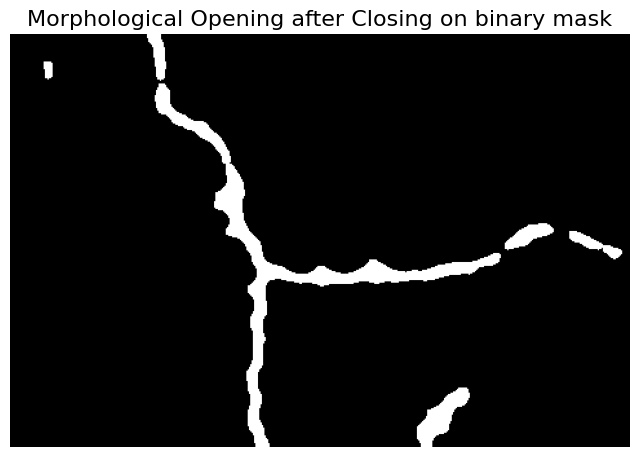

In [87]:
ksize = 6
mag_open = mag_close.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
mag_open = cv2.morphologyEx(mag_open, cv2.MORPH_OPEN, kernel_grad)
show(mag_open, "Morphological Opening after Closing on binary mask", filename="./output/sobel_morph_open_1.png")


### Closing one more time

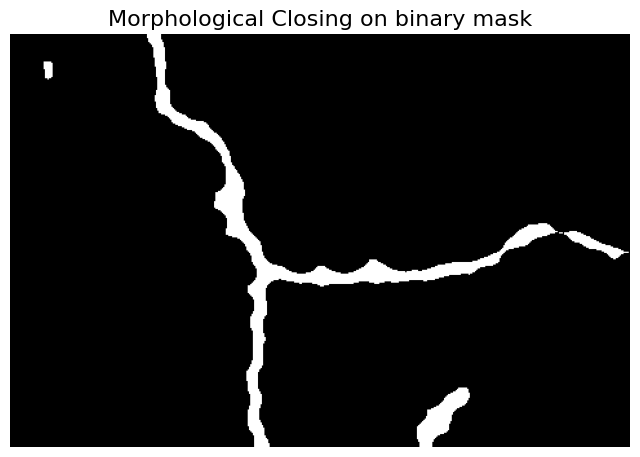

In [88]:
ksize = 21
mag_close = mag_open.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
mag_close = cv2.morphologyEx(mag_close, cv2.MORPH_CLOSE, kernel_grad)
show(mag_close, "Morphological Closing on binary mask", filename=f"./output/sobel_morph_close_2.png")


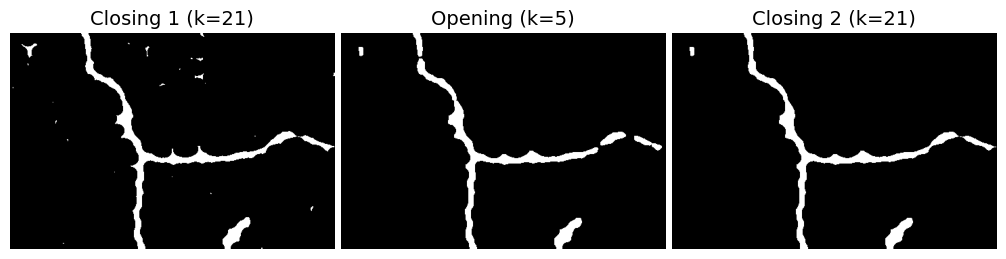

In [89]:
im1 = cv2.imread('./output/sobel_morph_close_1.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('./output/sobel_morph_open_1.png', cv2.IMREAD_GRAYSCALE)
im3 = cv2.imread('./output/sobel_morph_close_2.png', cv2.IMREAD_GRAYSCALE)
grid_images([im1,  im2, im3], ["Closing 1 (k=21)", "Opening (k=5)", "Closing 2 (k=21)"], 1, 3, bg_color=255, save_path="./output/sobel_close_open_close.png")

## Bottom-hat

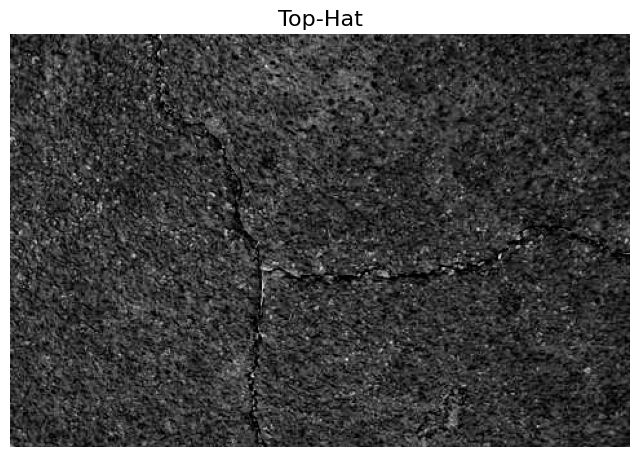

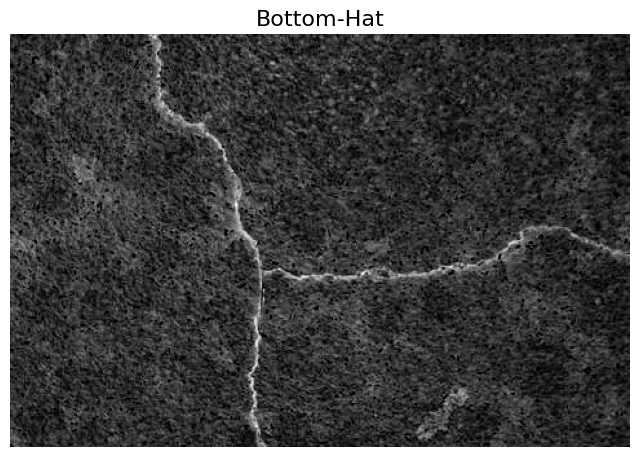

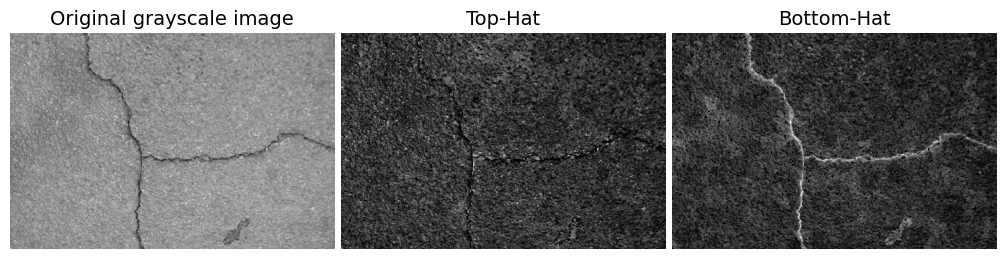

In [90]:
ksize = 21

gray = gray.copy().astype(np.uint8)

se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))

opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, se)
tophat = cv2.subtract(gray, opened)
# print(all(tophat == gray))
show(tophat, "Top-Hat", filename="./output/tophat.png")

closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, se)
bothat = cv2.subtract(closed, gray)
show(bothat, "Bottom-Hat", filename="./output/bothat.png")

grid_images([gray, tophat, bothat], ["Original grayscale image", "Top-Hat", "Bottom-Hat"], 1, 3, bg_color=255, save_path="./output/tophat_bottomhat.png")

#### Sobel on Bottom-hat

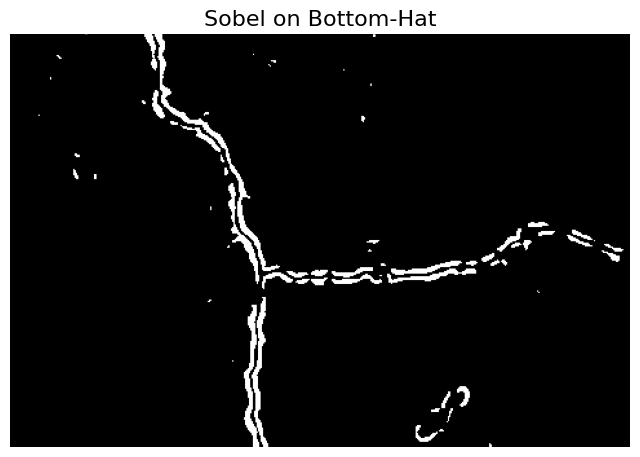

In [91]:
ksize = 21
global_threshold_ratio = 3

bothat = bothat.astype(np.float32) / 255.0  

gx = cv2.Sobel(bothat, cv2.CV_64F, 1, 0, ksize=ksize)
gy = cv2.Sobel(bothat, cv2.CV_64F, 0, 1, ksize=ksize)
bothat_mag = np.hypot(gx, gy)

threshold_raw = global_threshold_ratio * np.mean(bothat_mag)

bothat_mag_binary = np.zeros_like(bothat_mag, dtype=np.uint8)
bothat_mag_binary[bothat_mag > threshold_raw] = 255

bothat_mag_vis = bothat_mag_binary.copy()

show(bothat_mag_vis, "Sobel on Bottom-Hat", filename="./output/sobel_bothat.png")


### Closing on the result image

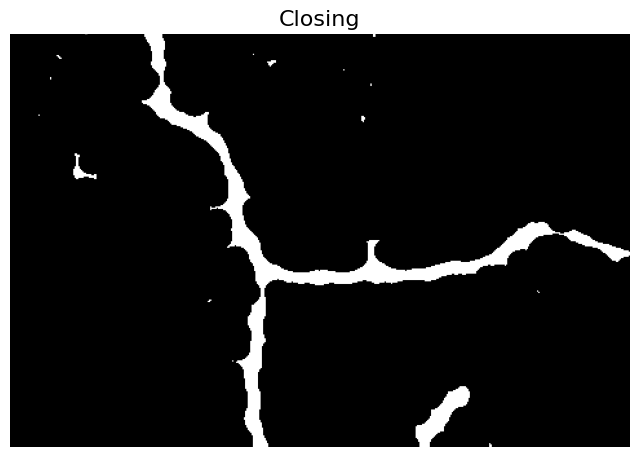

In [92]:
ksize = 21
bothat_mag_close = bothat_mag_binary.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
bothat_mag_close = cv2.morphologyEx(bothat_mag_close, cv2.MORPH_CLOSE, kernel_grad)
show(bothat_mag_close, "Closing", filename=f"./output/bothat_sobel_close.png")


### Opening

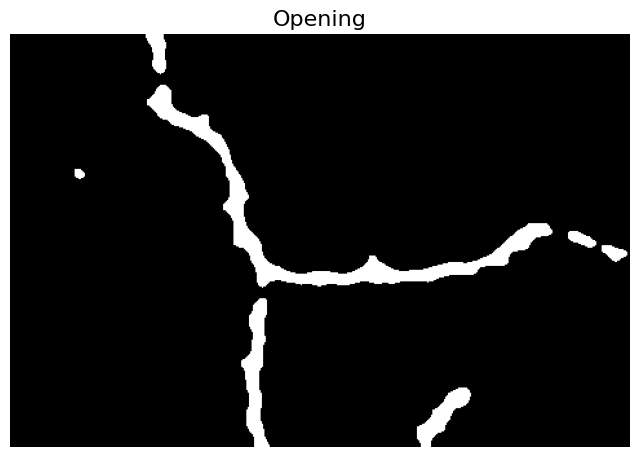

In [93]:
ksize = 6
bothat_mag_open = bothat_mag_close.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
bothat_mag_open = cv2.morphologyEx(bothat_mag_open, cv2.MORPH_OPEN, kernel_grad)
show(bothat_mag_open, "Opening", filename=f"./output/bothat_sobel_open.png")


### Closing one more time

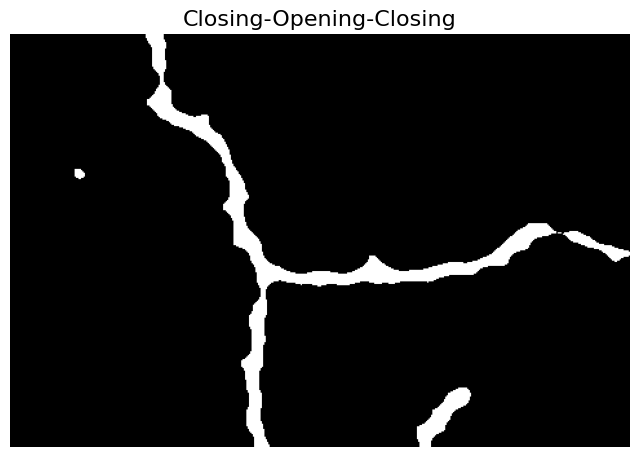

In [94]:
ksize = 21
bothat_mag_close = bothat_mag_open.astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
bothat_mag_close = cv2.morphologyEx(bothat_mag_close, cv2.MORPH_CLOSE, kernel_grad)
show(bothat_mag_close, "Closing-Opening-Closing", filename=f"./output/bothat_sobel_close_open_close.png")

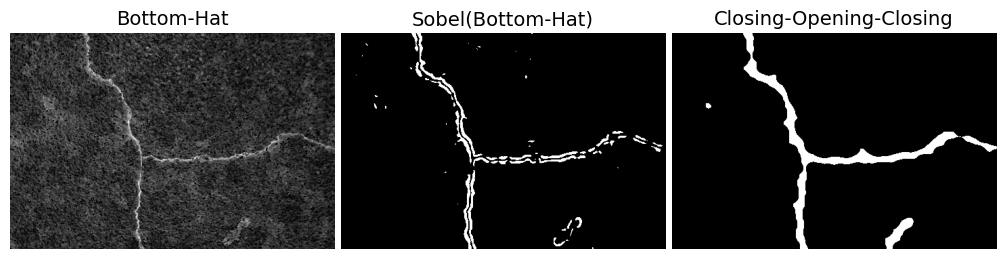

In [95]:
grid_images(
    [bothat, bothat_mag_vis, bothat_mag_close],
    ["Bottom-Hat", "Sobel(Bottom-Hat)", "Closing-Opening-Closing"],
    1, 3,
    bg_color=255,
    save_path="./output/bothat_full.png"
)

# Sobel + Laplacian of Gaussian (LoG)

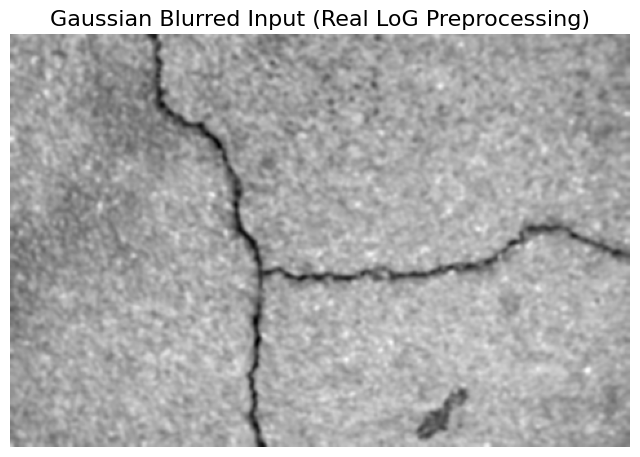

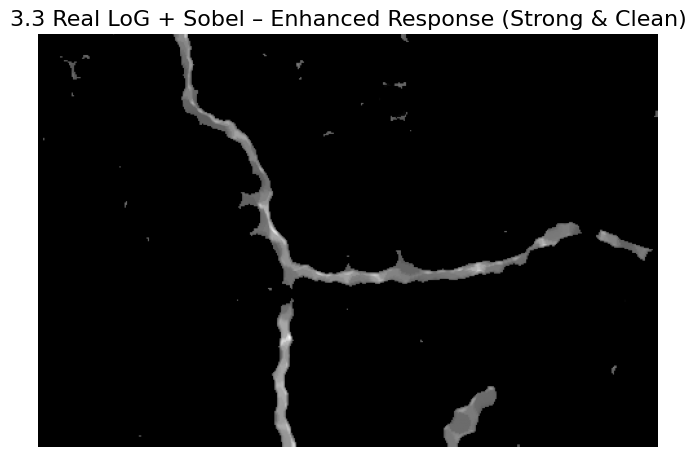

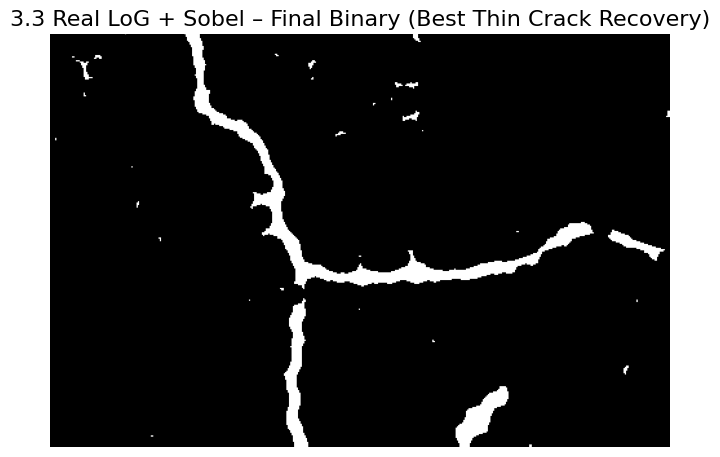

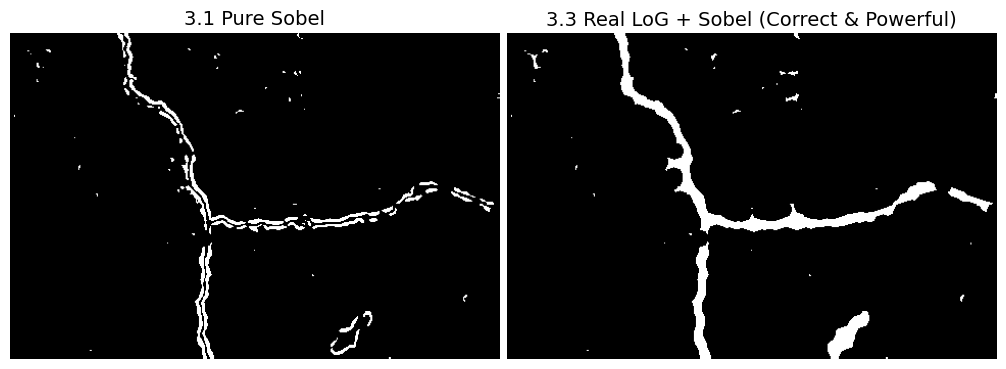

In [96]:
lap_ksize = 5           
lap_sigma = 1.4         
lap_weight = 2.2 
global_threshold_ratio = 2.6

# Step 1: Proper Gaussian blur with correct kernel size
# OpenCV rule: kernel_size = 0 → auto, but we want full control
kernel_size = int(4 * lap_sigma) * 2 + 1    # Standard rule: cover ~4×sigma on each side
kernel_size = max(kernel_size, 5)           # Minimum 5x5
kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1  # Force odd

blurred = cv2.GaussianBlur(gray_norm, (kernel_size, kernel_size), sigmaX=lap_sigma, sigmaY=lap_sigma)

show(blurred, "Gaussian Blurred Input (Real LoG Preprocessing)")

# Step 2: Laplacian on properly blurred image
lap = cv2.Laplacian(blurred, cv2.CV_64F, ksize=lap_ksize)
lap_abs = lap

# Step 3: Robust scaling using 99.5th percentile
p99 = np.percentile(lap_abs, 99.5)
lap_boost = lap_abs / (p99 + 1e-8)

# Step 4: Scale Sobel magnitude properly
mag_mean = np.mean(mag_raw)
mag_scaled = mag_raw / (mag_mean + 1e-8)

# Step 5: Combine — Laplacian now gives clean, strong boost only on thin cracks
combined = mag_scaled + lap_weight * lap_boost

# Step 6: Threshold
threshold = global_threshold_ratio * np.mean(combined)
combined[combined < threshold] = 0

# Step 7: Closing to connect
ksize_close = 9
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize_close, ksize_close))
closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 8: Final binary
binary_log = (closed > 0).astype(np.uint8) * 255

# Visualizations
vis = cv2.normalize(closed, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
show(vis, "3.3 Real LoG + Sobel – Enhanced Response (Strong & Clean)")
show(binary_log, "3.3 Real LoG + Sobel – Final Binary (Best Thin Crack Recovery)")

# Compare all methods
grid_images(
    [mag_raw_binary, binary_log],
    ["3.1 Pure Sobel", "3.3 Real LoG + Sobel (Correct & Powerful)"],
    1, 2,
    save_path="./output/sobel_vs_real_log.png"
)

# Canny Edge

### Sobel after Gaussian vs pure Sobel

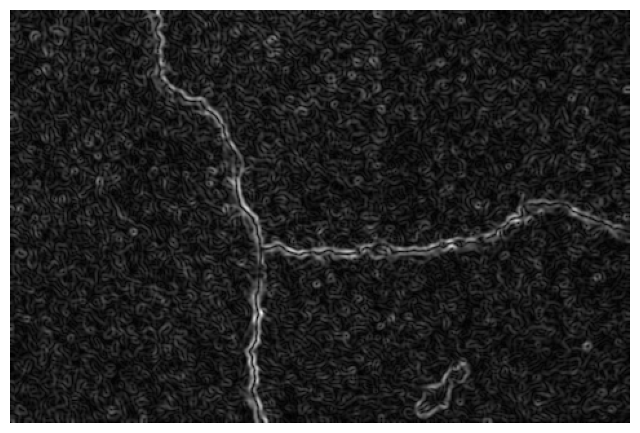

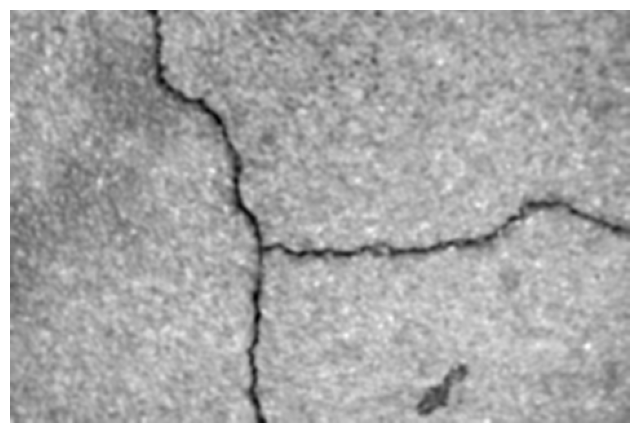

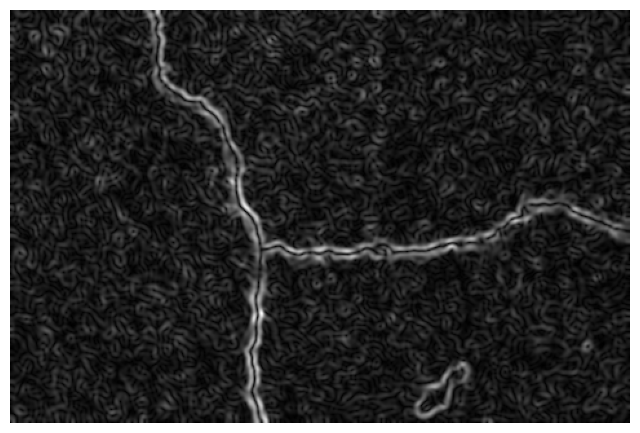

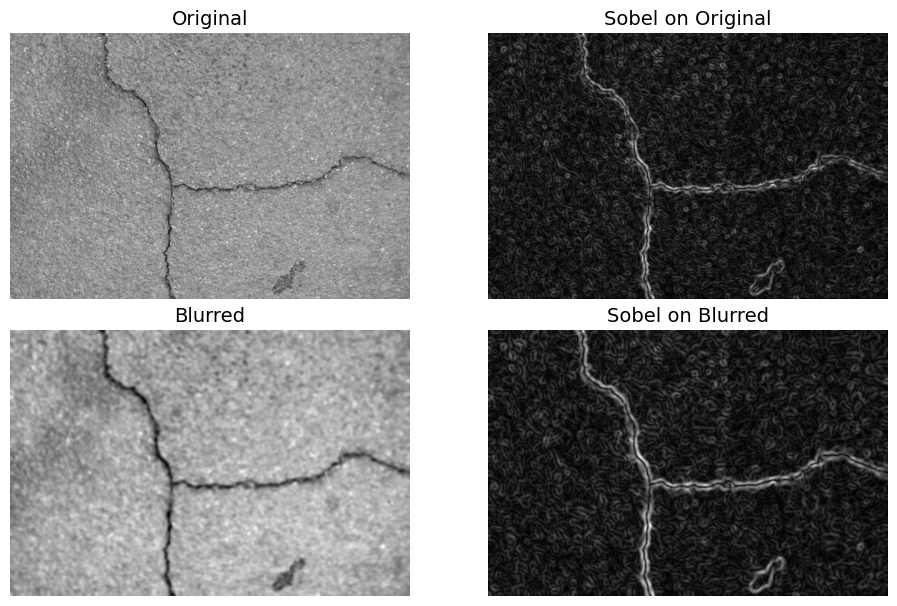

In [97]:
gaussian_ksize = 9
sobel_ksize = 9

gray_norm = gray.astype(np.float32) / 255.0

gx = cv2.Sobel(gray_norm, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
gy = cv2.Sobel(gray_norm, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
mag = np.hypot(gx, gy)
show(mag)
 

blurred = cv2.GaussianBlur(gray_norm, (gaussian_ksize,gaussian_ksize), sigmaX=1.5)
show(blurred)
gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
mag_blurred = np.hypot(gx, gy)
show(mag_blurred)

grid_images([gray, mag, blurred, mag_blurred], [ "Original", "Sobel on Original", "Blurred", "Sobel on Blurred"], 2, 2, save_path="./output/sobel_blur_comparison.png")

### Canny

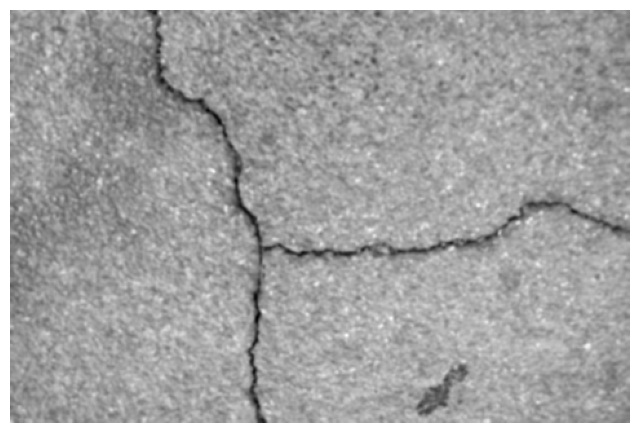

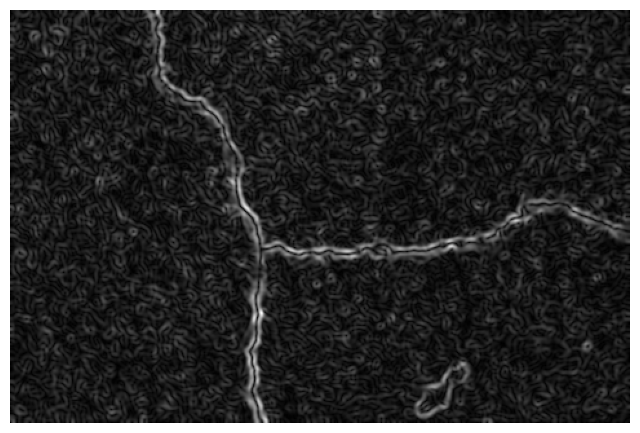

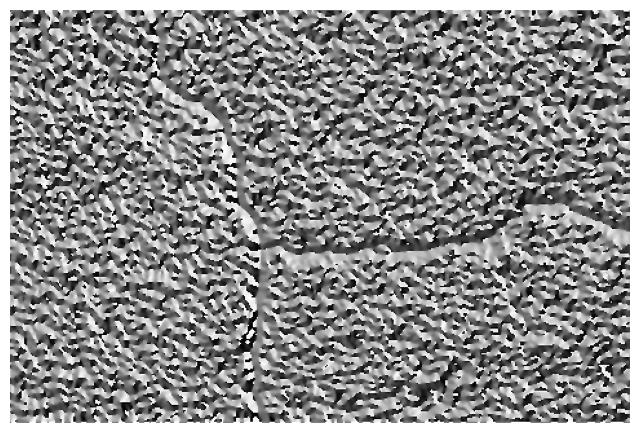

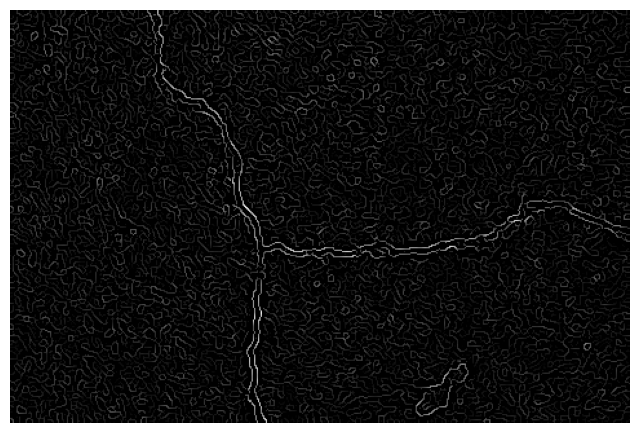

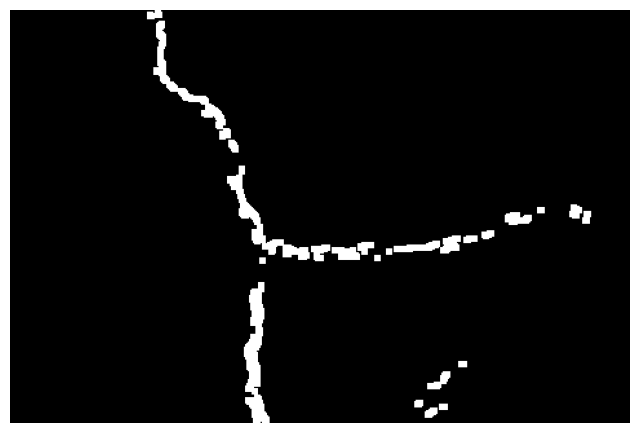

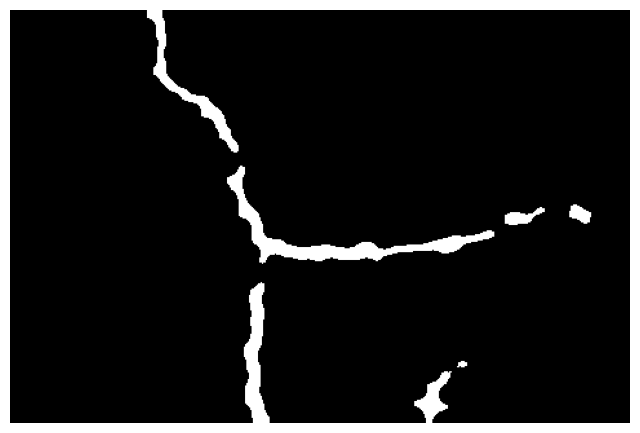

In [98]:
gaussian_ksize = 9
sobel_ksize = 9
dilate_ksize = 5
close_ksize = 15
open_ksize = 5

gray_norm = gray.astype(np.float32) / 255.0

blurred = cv2.GaussianBlur(gray_norm, (gaussian_ksize,gaussian_ksize), sigmaX=1.0)
show(blurred)
gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
mag = np.hypot(gx, gy)
show(mag)
ang = np.arctan2(gy, gx)
show(ang)

def non_max_suppression_manual(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4 
    winE  = np.array([[0,0,0],[1,1,1],[0,0,0]])  
    winSE = np.array([[1,0,0],[0,1,0],[0,0,1]])  
    winS  = np.array([[0,1,0],[0,1,0],[0,1,0]]) 
    winSW = np.array([[0,0,1],[0,1,0],[1,0,0]])  

    def nms_dir(data, win):
        data_max = ndimage.maximum_filter(data, footprint=win, mode='constant')
        return np.where(data == data_max, data, 0)

    nms = np.zeros_like(mag)
    nms[ang_quant == 0] = nms_dir(mag, winE)[ang_quant == 0]
    nms[ang_quant == 1] = nms_dir(mag, winSE)[ang_quant == 1]
    nms[ang_quant == 2] = nms_dir(mag, winS)[ang_quant == 2]
    nms[ang_quant == 3] = nms_dir(mag, winSW)[ang_quant == 3]
    
    return nms

mag_nms = non_max_suppression_manual(mag, ang)
show(mag_nms)

high_thresh = 0.5 * mag_nms.max()
low_thresh  = 0.2 * mag_nms.max()

high_mask = mag_nms > high_thresh
low_mask  = mag_nms > low_thresh

edges = np.zeros_like(mag_nms, dtype=np.uint8)
edges[high_mask] = 255

edges = cv2.dilate(edges, np.ones((dilate_ksize, dilate_ksize), np.uint8), iterations=1) 
edges[low_mask] = np.where(edges[low_mask] > 0, 255, 0)
show(edges)

close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
manual_canny = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, close_kernel)
manual_canny = cv2.morphologyEx(manual_canny, cv2.MORPH_OPEN, open_kernel)
manual_canny = cv2.morphologyEx(manual_canny, cv2.MORPH_CLOSE, close_kernel)

show(manual_canny, filename="./output/manual_canny.png")

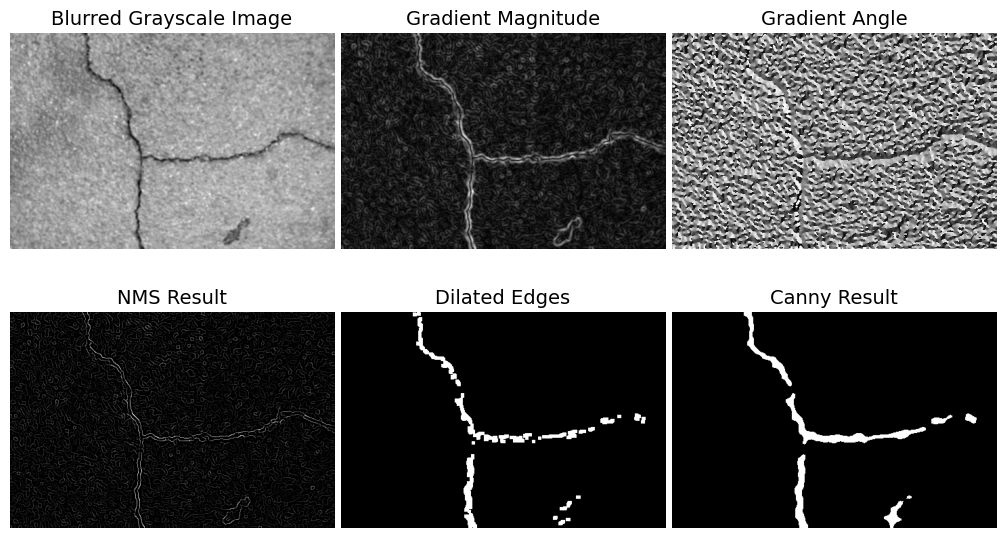

In [99]:
grid_images([blurred, mag, ang, mag_nms, edges, manual_canny], ["Blurred Grayscale Image", "Gradient Magnitude", "Gradient Angle", "NMS Result", "Dilated Edges", "Canny Result"], 2, 3, save_path="./output/canny_full.png")

# Fourier transform

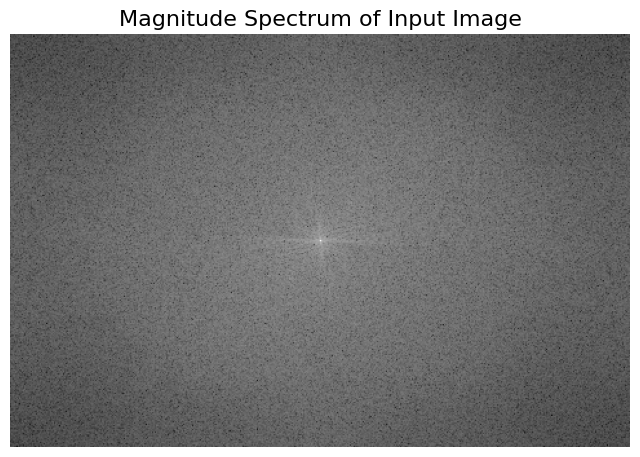

In [100]:
dft = cv2.dft(np.float32(gray_norm), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
show(magnitude_spectrum, "Magnitude Spectrum of Input Image")




In [101]:
rows, cols = gray_norm.shape
crow, ccol = rows // 2, cols // 2

# Radius of the low-pass circle
R = 10   # <--- adjust this

# Create circular low-pass mask
mask = np.zeros((rows, cols, 2), np.float32)

Y, X = np.ogrid[:rows, :cols]
dist_from_center = (X - ccol)**2 + (Y - crow)**2

mask[dist_from_center <= R*R] = 1
dft_shift_cut = dft_shift * mask

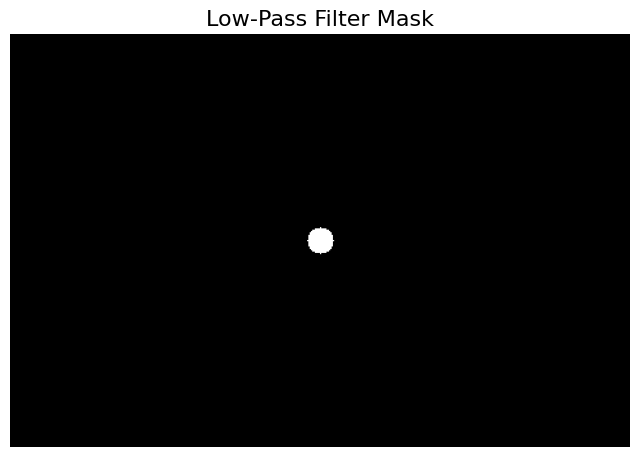

In [102]:
show(mask[:,:,0], "Low-Pass Filter Mask")

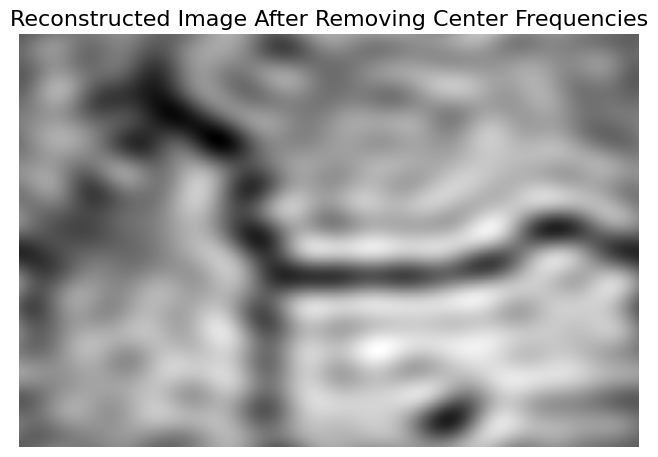

In [103]:
f_ishift = np.fft.ifftshift(dft_shift_cut)
img_back_complex = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back_complex[:,:,0], img_back_complex[:,:,1])
img_back_norm = cv2.normalize(img_back, None, 0, 1, cv2.NORM_MINMAX)
show(img_back_norm, "Reconstructed Image After Removing Center Frequencies")

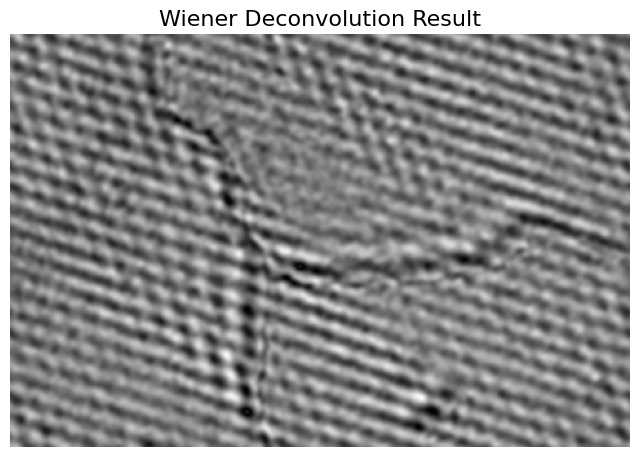

In [104]:
import cv2
import numpy as np

# --- 1. Your grayscale image ---
# gray_norm is float32 normalized [0,1]
img = gray_norm.copy()

# --- 2. Create a Gaussian PSF (point spread function) ---
psf_size = 13     # kernel size
psf_sigma = 2     # blur radius

gk1d = cv2.getGaussianKernel(psf_size, psf_sigma)
psf = gk1d @ gk1d.T   # 2D Gaussian PSF

# --- 3. Wiener deconvolution function ---
def wiener_deconvolution(img, psf, K):
    eps = 1e-8
    IMG = np.fft.fft2(img)
    PSF = np.fft.fft2(psf, s=img.shape)
    
    PSF_conj = np.conj(PSF)
    PSF_conj = PSF

    # Wiener filter
    wiener = PSF_conj / (PSF * PSF_conj + K + eps)

    F_est = wiener * IMG
    result = np.fft.ifft2(F_est)
    
    return np.abs(result)

K = 0.5  

deconv = wiener_deconvolution(img, psf, K)

# --- 5. Normalize result for display ---
deconv_norm = cv2.normalize(deconv, None, 0, 1, cv2.NORM_MINMAX)

show(deconv_norm, "Wiener Deconvolution Result")


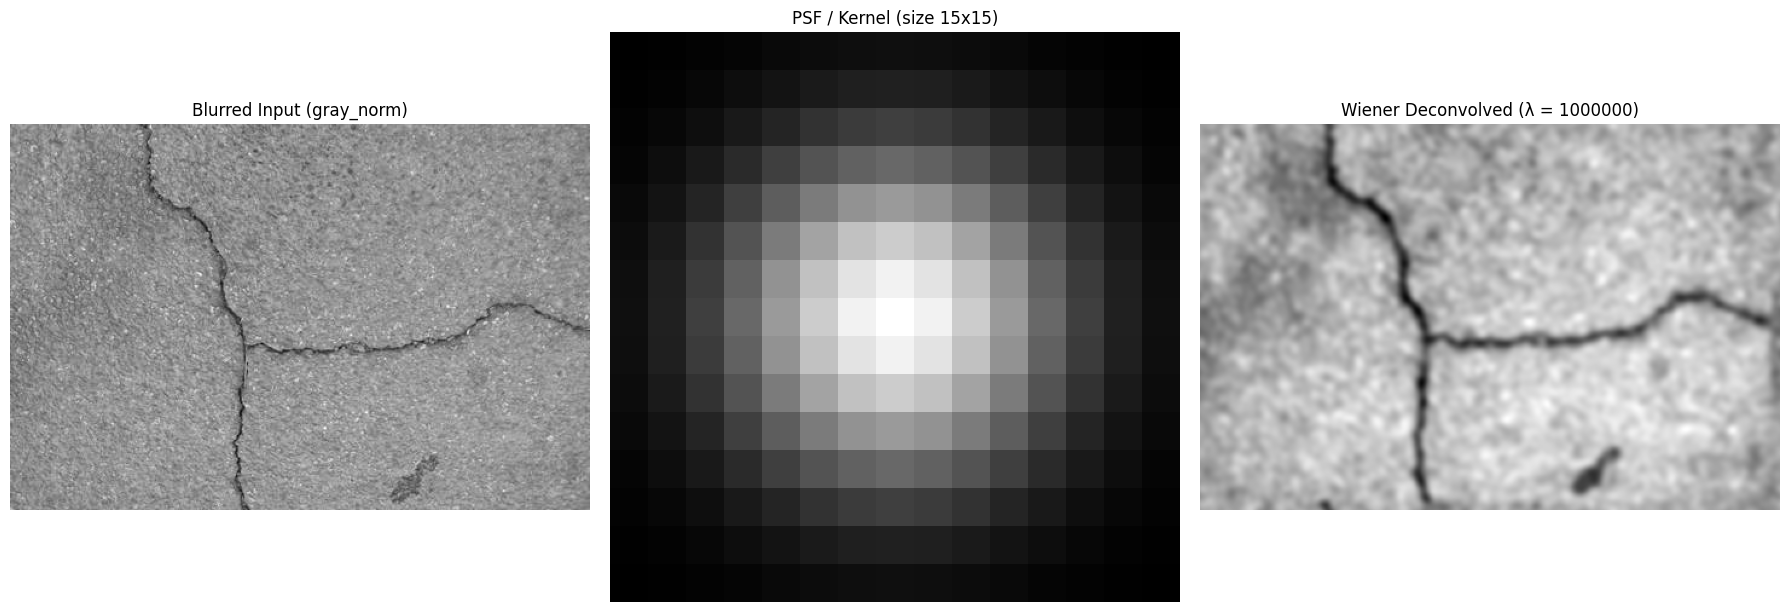

True

In [105]:
kernel_size = 15
sigma = 3.0
kernel = np.fromfunction(
    lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(kernel_size-1)/2)**2 + (y-(kernel_size-1)/2)**2)/(2*sigma**2)),
    (kernel_size, kernel_size)
)
kernel = kernel / kernel.sum()   # normalize

# You can also use motion blur, out-of-focus, etc. Just make sure it's normalized

# ------------------- 3. Wiener Deconvolution -------------------
def wiener_deconvolution(image, kernel, lambda_reg=0.01):
    # Pad kernel to image size
    padded_kernel = np.zeros_like(image)
    kh, kw = kernel.shape
    padded_kernel[:kh, :kw] = kernel
    
    # FFTs
    H = np.fft.fft2(padded_kernel)
    G = np.fft.fft2(image)
    
    # Conjugate of H
    H_conj = np.conj(H)
    
    # Wiener filter (exactly the formula from your slide)
    denominator = np.abs(H)**2 + lambda_reg
    Wiener_filter = H_conj / denominator
    
    # Restore
    F_restored = G * Wiener_filter
    restored = np.fft.ifft2(F_restored)
    restored = np.abs(restored)          # remove negligible imaginary part
    restored = np.clip(restored, 0, 1)
    
    return restored

# ------------------- 4. Run it -------------------
lambda_reg = 1000000         # Try values: 0.001 (sharper), 0.05 (smoother)
restored_image = wiener_deconvolution(gray_norm, kernel, lambda_reg=lambda_reg)

# ------------------- 5. Show results -------------------
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Blurred Input (gray_norm)")
plt.imshow(gray_norm, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"PSF / Kernel (size {kernel_size}x{kernel_size})")
kernel_vis = kernel / kernel.max()
plt.imshow(kernel_vis, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Wiener Deconvolved (λ = {lambda_reg})")
plt.imshow(restored_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# ------------------- Save result (optional) -------------------
cv2.imwrite('wiener_restored.jpg', (restored_image * 255).astype(np.uint8))

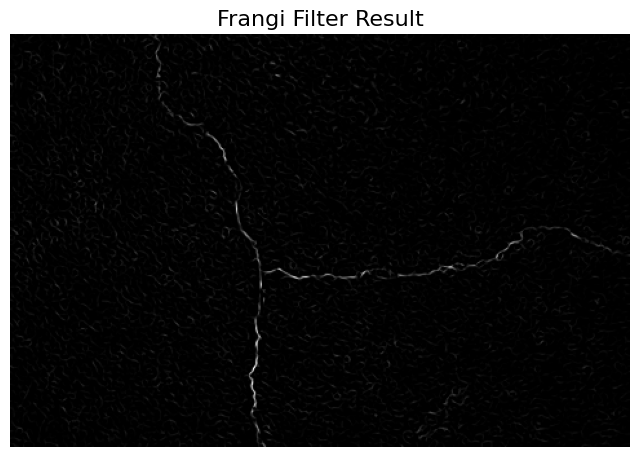

In [106]:
from skimage.filters import frangi

fr = frangi(gray_norm,
            sigmas=range(1, 9),   # scales 1–5
            alpha=0.6,
            beta=0.6,
            gamma=4,
            black_ridges=True)
show(fr, "Frangi Filter Result", filename="./output/frangi_result.png")

# Histogram suppression

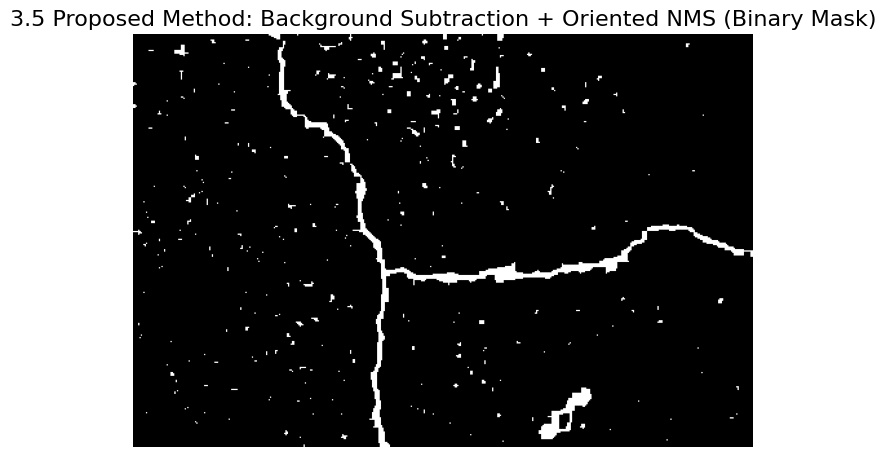

In [107]:
sigma = 10
fudgefactor = 0.8

gray_norm = gray.astype(np.float32) / 255.0
blur = cv2.GaussianBlur(gray_norm, (2*math.ceil(2*sigma)+1,)*2, sigma)
enhanced = cv2.subtract(gray_norm, blur)

# Optional: clip extreme values (your improved version)
high = np.percentile(enhanced, 50)
enhanced = np.clip(enhanced, None, high)
enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min() + 1e-8)

# Sobel on enhanced image
sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
mag = np.hypot(sobelx, sobely)
ang = np.arctan2(sobely, sobelx)

# Threshold
threshold = 4 * fudgefactor * np.mean(mag)
mag[mag < threshold] = 0

# Oriented Non-Maximum Suppression (your key contribution)
def non_max_suppression(data, win):
    data_max = ndimage.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    
    winE  = np.array([[0,0,0],[1,1,1],[0,0,0]])
    winSE = np.array([[1,0,0],[0,1,0],[0,0,1]])
    winS  = np.array([[0,1,0],[0,1,0],[0,1,0]])
    winSW = np.array([[0,0,1],[0,1,0],[1,0,0]])

    magE  = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS  = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    result = np.zeros_like(mag)
    result[ang_quant == 0] = magE[ang_quant == 0]
    result[ang_quant == 1] = magSE[ang_quant == 1]
    result[ang_quant == 2] = magS[ang_quant == 2]
    result[ang_quant == 3] = magSW[ang_quant == 3]
    return result

mag_nms = orientated_non_max_suppression(mag, ang)

# Final binary
binary = np.zeros_like(mag_nms, dtype=np.uint8)
binary[mag_nms > 0] = 255

kernel_close = np.ones((5,5), np.uint8)
proposed_final = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close)

show(proposed_final, "3.5 Proposed Method: Background Subtraction + Oriented NMS (Binary Mask)")



## Histogram plot

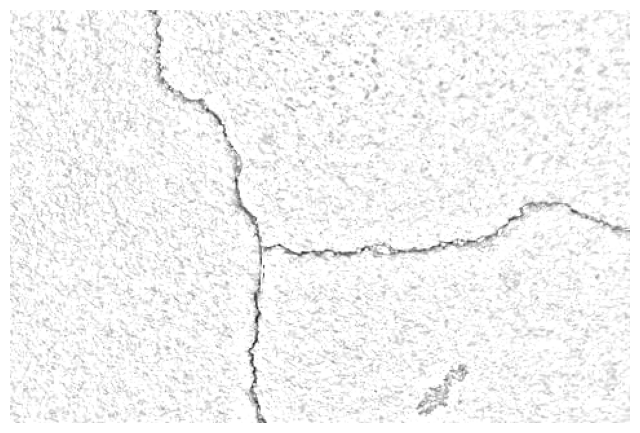

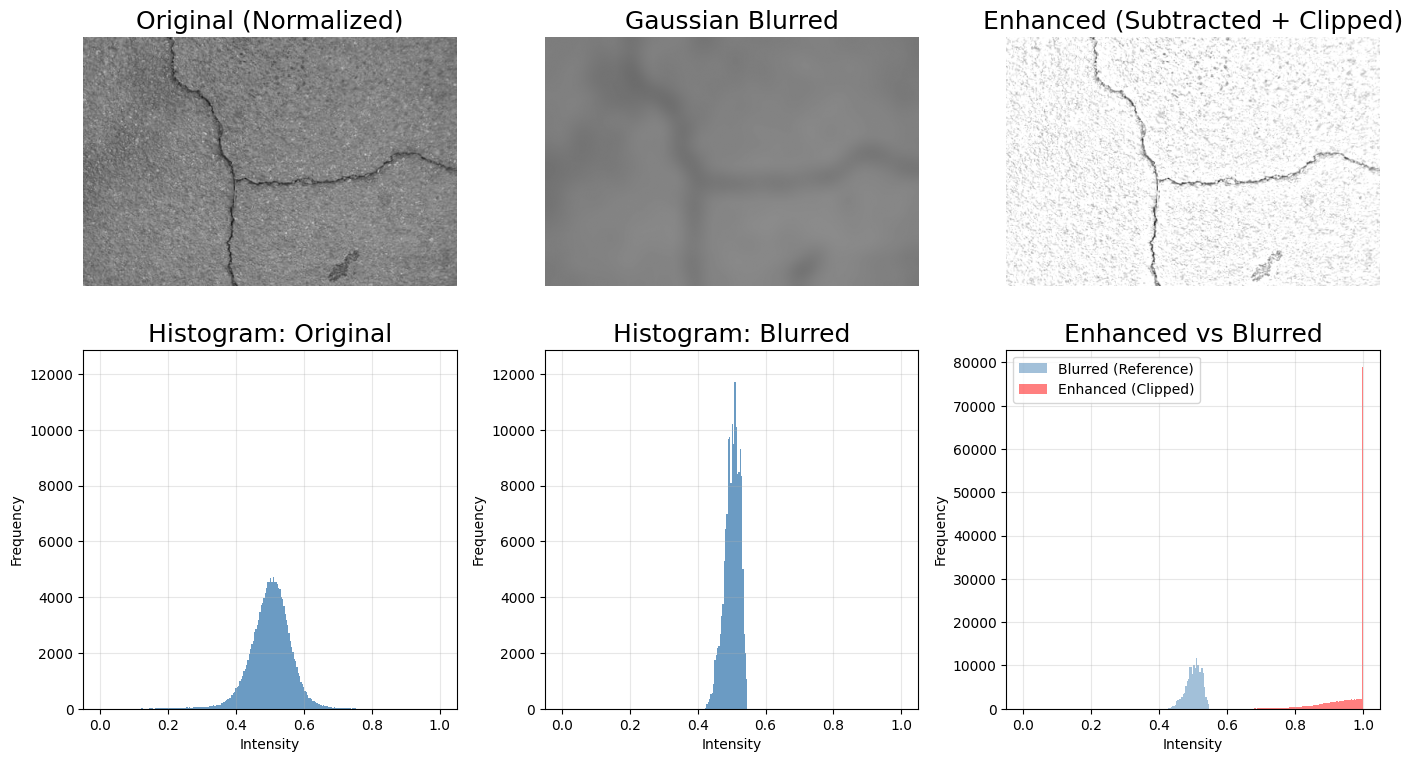

In [108]:
sigma = 11

gray_norm = gray.astype(np.float32) / 255.0
blur = cv2.GaussianBlur(gray_norm, (2*math.ceil(2*sigma)+1,)*2, sigma)
enhanced = cv2.subtract(gray_norm, blur)

high = np.percentile(enhanced, 50)
enhanced = np.clip(enhanced, None, high)
enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min() + 1e-8)
show(enhanced, filename="./output/hist_enhanced.png")

# NumPy histogram parameters
hist_np_kwargs = dict(bins=256, range=(0.0, 1.0), density=False)

# Compute histograms
hist_orig, _ = np.histogram(gray_norm, **hist_np_kwargs)
hist_blur, _ = np.histogram(blur, **hist_np_kwargs)
hist_enh, _ = np.histogram(enhanced, **hist_np_kwargs)

ymax = max(hist_orig.max(), hist_blur.max()) * 1.1

# Plot,
fig = plt.figure(figsize=(14, 8))

titles_img = ["Original (Normalized)", 
              "Gaussian Blurred", 
              "Enhanced (Subtracted + Clipped)"]
imgs = [gray_norm, blur, enhanced]

for i, im in enumerate(imgs):
    plt.subplot(2, 3, i+1)
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    plt.title(titles_img[i], fontsize=18)
    plt.axis('off')

# Plot
hist_plot_kwargs = dict(bins=256, range=(0.0, 1.0), density=False, alpha=0.8, linewidth=0.8)

hist_data = [gray_norm, blur]
titles_hist = ["Histogram: Original", 
               "Histogram: Blurred"]
clip_val = high

for i, data in enumerate(hist_data):
    plt.subplot(2, 3, 4 + i)
    plt.hist(data.ravel(), color='steelblue', **hist_plot_kwargs)
    plt.ylim(0, ymax)
    plt.title(titles_hist[i], fontsize=18)
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4 + 2)
plt.hist(blur.ravel(), bins=256, range=(0,1), alpha=0.5, color='steelblue', label='Blurred (Reference)')
plt.hist(enhanced.ravel(), bins=256, range=(0,1), alpha=0.5, color='red', label='Enhanced (Clipped)')
plt.title("Enhanced vs Blurred", fontsize=18)
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.suptitle('Background Subtraction Analysis: Images and Histograms', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig("./output/enhancement_histograms.png")
plt.show()

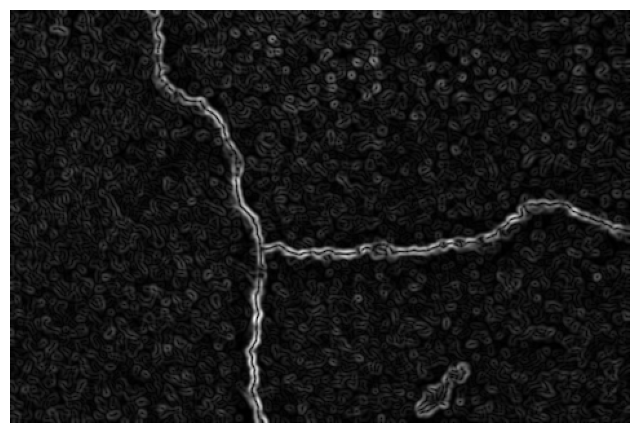

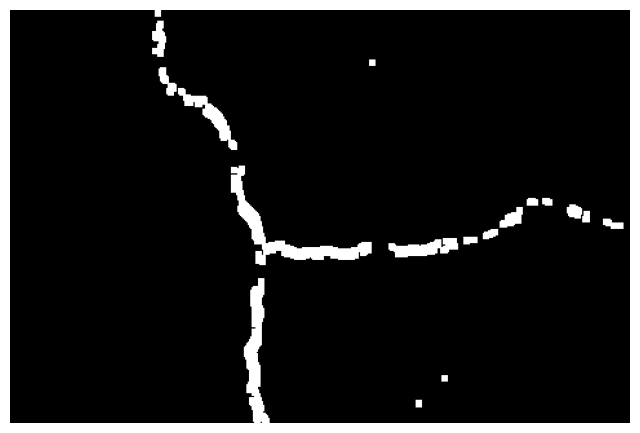

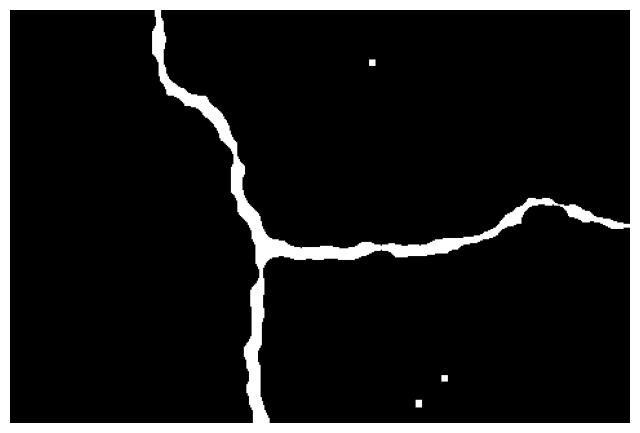

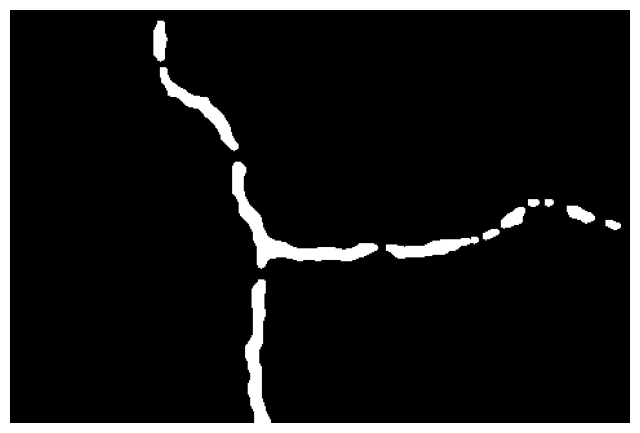

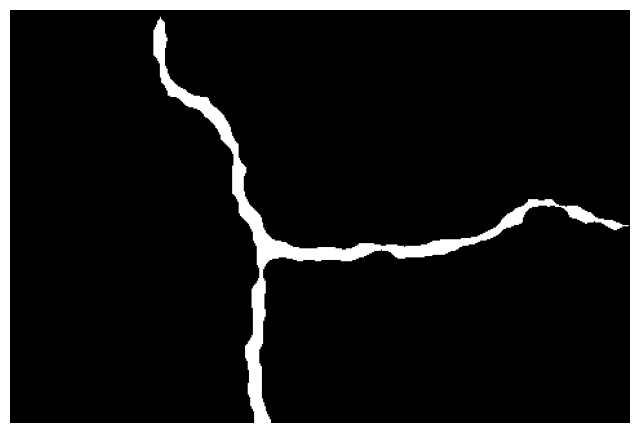

In [109]:
sobel_ksize = 9

sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
sobely = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
mag = np.hypot(sobelx, sobely)
ang = np.arctan2(sobely, sobelx)
show(mag, filename="./output/his_sobel_magnitude.png")

global_threshold_ratio = 3
threshold = global_threshold_ratio * np.mean(mag)
mag[mag < threshold] = 0

# Oriented NMS
def non_max_suppression(data, win):
    data_max = ndimage.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4

    winE  = np.array([[0,0,0],[1,1,1],[0,0,0]])
    winSE = np.array([[1,0,0],[0,1,0],[0,0,1]])
    winS  = np.array([[0,1,0],[0,1,0],[0,1,0]])
    winSW = np.array([[0,0,1],[0,1,0],[1,0,0]])

    magE  = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS  = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    result = np.zeros_like(mag)
    result[ang_quant == 0] = magE[ang_quant == 0]
    result[ang_quant == 1] = magSE[ang_quant == 1]
    result[ang_quant == 2] = magS[ang_quant == 2]
    result[ang_quant == 3] = magSW[ang_quant == 3]
    return result

mag_nms = orientated_non_max_suppression(mag, ang)

high_thresh = 0.5 * mag_nms.max()
low_thresh  = 0.2 * mag_nms.max()

high_mask = mag_nms > high_thresh
low_mask  = mag_nms > low_thresh

edges = np.zeros_like(mag_nms, dtype=np.uint8)
edges[high_mask] = 255

dilate_ksize = 5
edges = cv2.dilate(edges, np.ones((dilate_ksize, dilate_ksize), np.uint8), iterations=1) 
edges[low_mask] = np.where(edges[low_mask] > 0, 255, 0)
show(edges, filename="./output/hist_sobel_nms_dilate.png")

close_ksize = 25
open_ksize = 6
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
proposed_final_c = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close)
show(proposed_final_c, filename="./output/hist_close.png")
proposed_final_c_o = cv2.morphologyEx(proposed_final_c, cv2.MORPH_OPEN, kernel_open)
show(proposed_final_c_o, filename="./output/hist_close_open.png")
proposed_final_c_o_c = cv2.morphologyEx(proposed_final_c_o, cv2.MORPH_CLOSE, kernel_close)
show(proposed_final_c_o_c, filename="./output/hist_close_open_close.png")

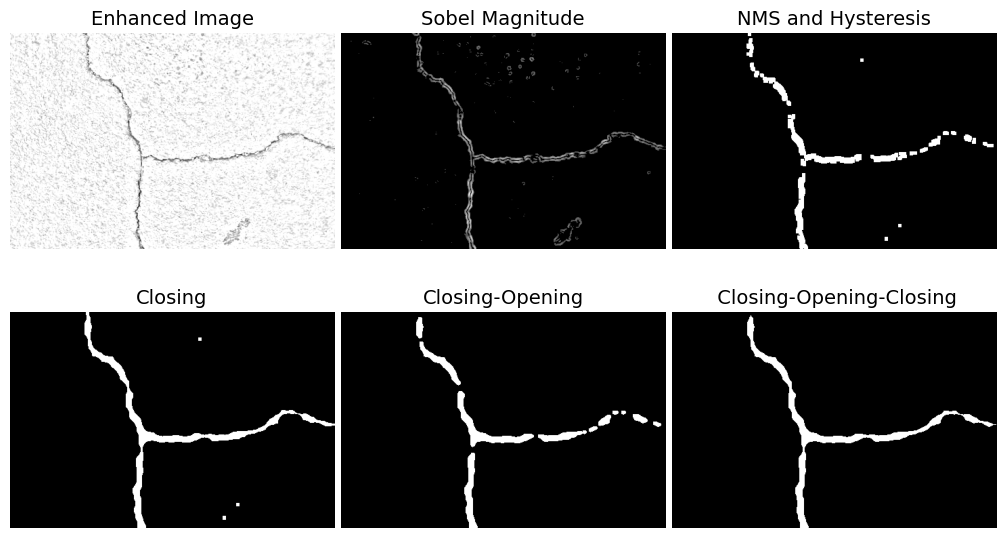

In [110]:
grid_images(
    [enhanced, mag, edges, proposed_final_c, proposed_final_c_o, proposed_final_c_o_c],
    ["Enhanced Image", "Sobel Magnitude", "NMS and Hysteresis", "Closing", "Closing-Opening", " Closing-Opening-Closing"],
    2, 3,
    save_path="./output/hist_full.png"
)

# Comparison


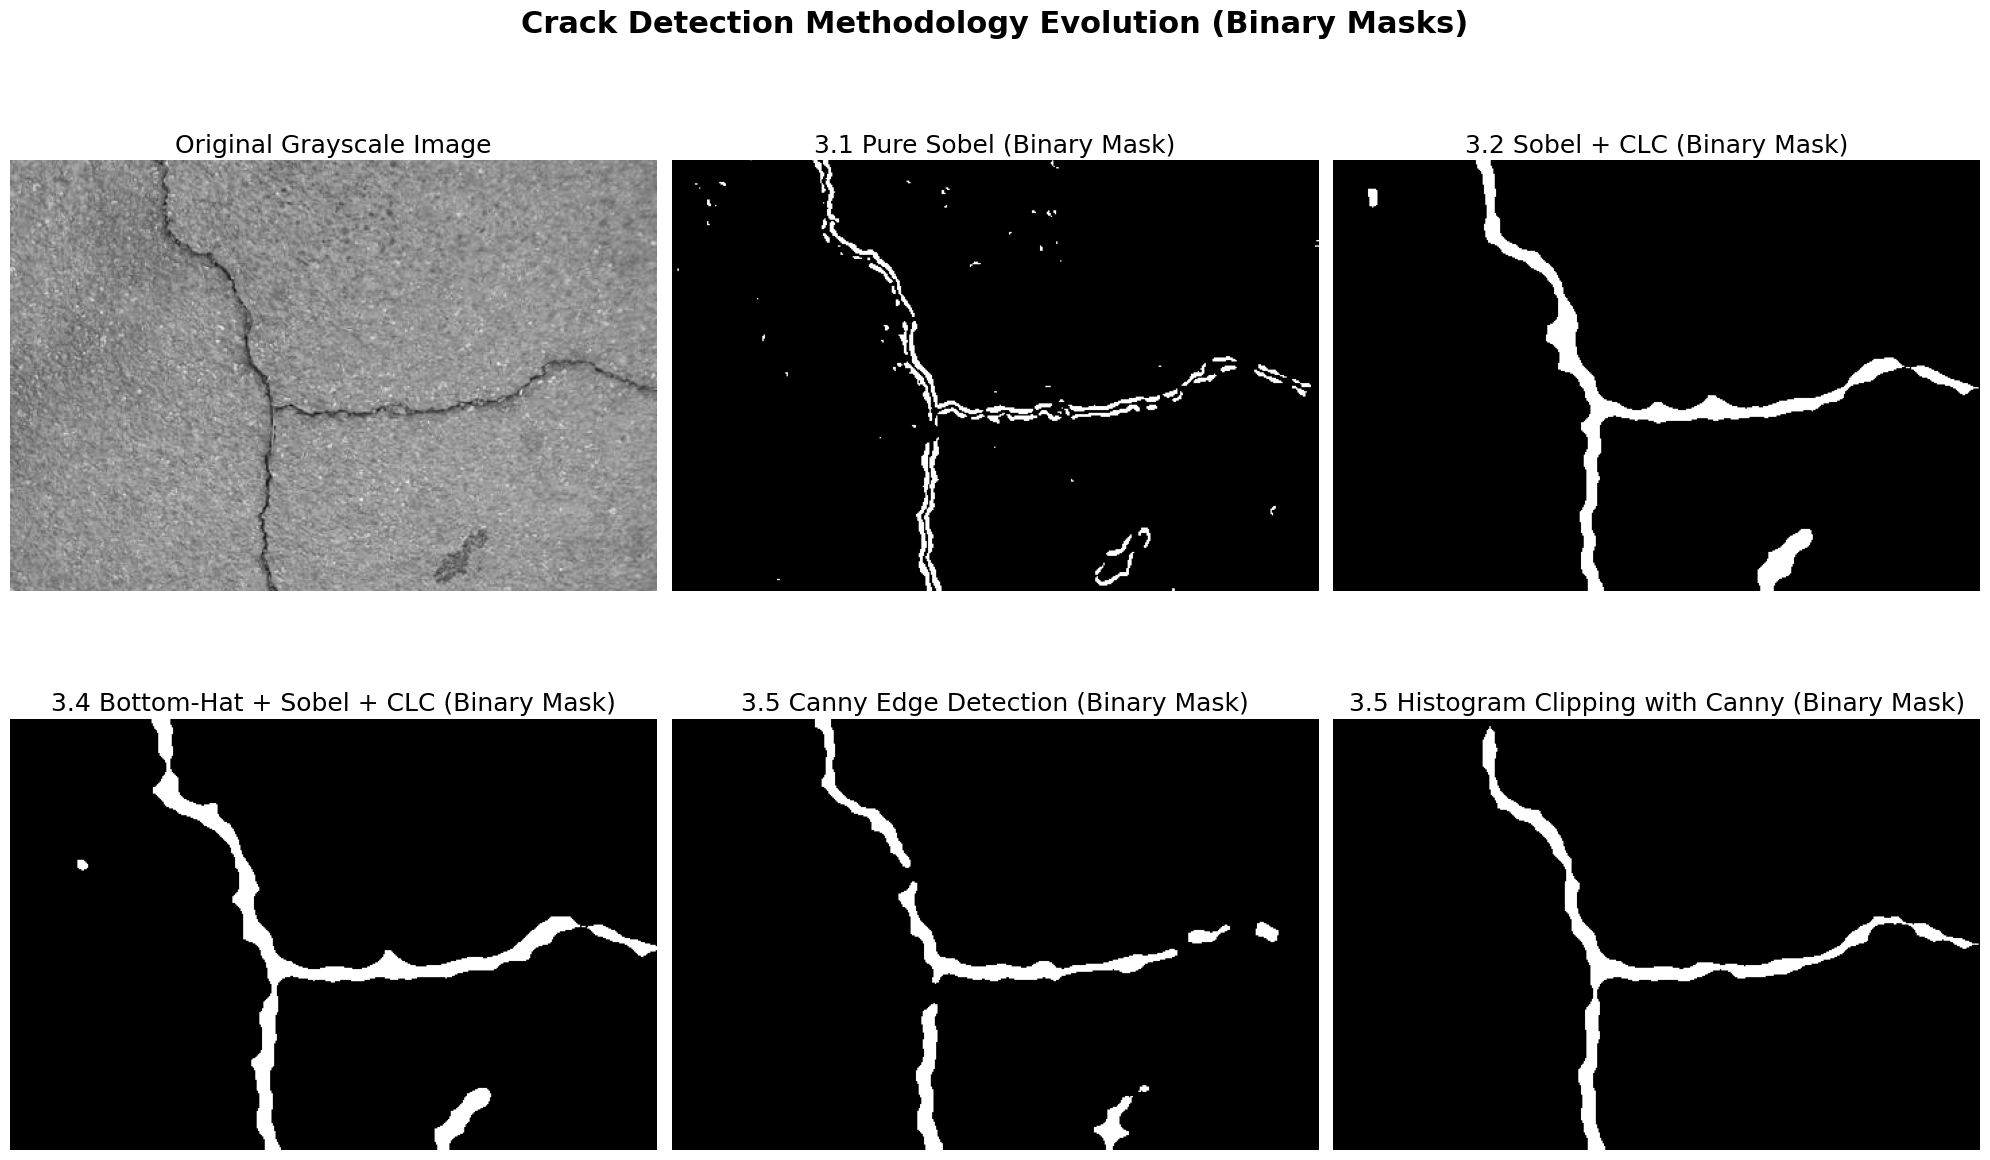

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.ravel()

vis_pure_sobel = cv2.imread('./output/sobel_only_15_3.png', cv2.IMREAD_GRAYSCALE)
vis_morph = cv2.imread('./output/sobel_morph_close_2.png', cv2.IMREAD_GRAYSCALE)
vis_bothat_sobel = cv2.imread('./output/bothat_sobel_close_open_close.png', cv2.IMREAD_GRAYSCALE)
vis_manual_canny = cv2.imread('./output/manual_canny.png', cv2.IMREAD_GRAYSCALE)
vis_hist_proposed = cv2.imread('./output/hist_close_open_close.png', cv2.IMREAD_GRAYSCALE)

images = [
    gray,
    vis_pure_sobel,
    vis_morph,
    vis_bothat_sobel,
    vis_manual_canny,
    vis_hist_proposed
]

titles = [
    "Original Grayscale Image",
    "3.1 Pure Sobel (Binary Mask)",
    "3.2 Sobel + CLC (Binary Mask)",
    "3.4 Bottom-Hat + Sobel + CLC (Binary Mask)",
    "3.5 Canny Edge Detection (Binary Mask)",
    "3.5 Histogram Clipping with Canny (Binary Mask)"
]

for i, (img, title) in enumerate(zip(images, titles)):
    if len(img.shape) == 3:
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title, fontsize=18)
    axes[i].axis('off')

plt.suptitle("Crack Detection Methodology Evolution (Binary Masks)", fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

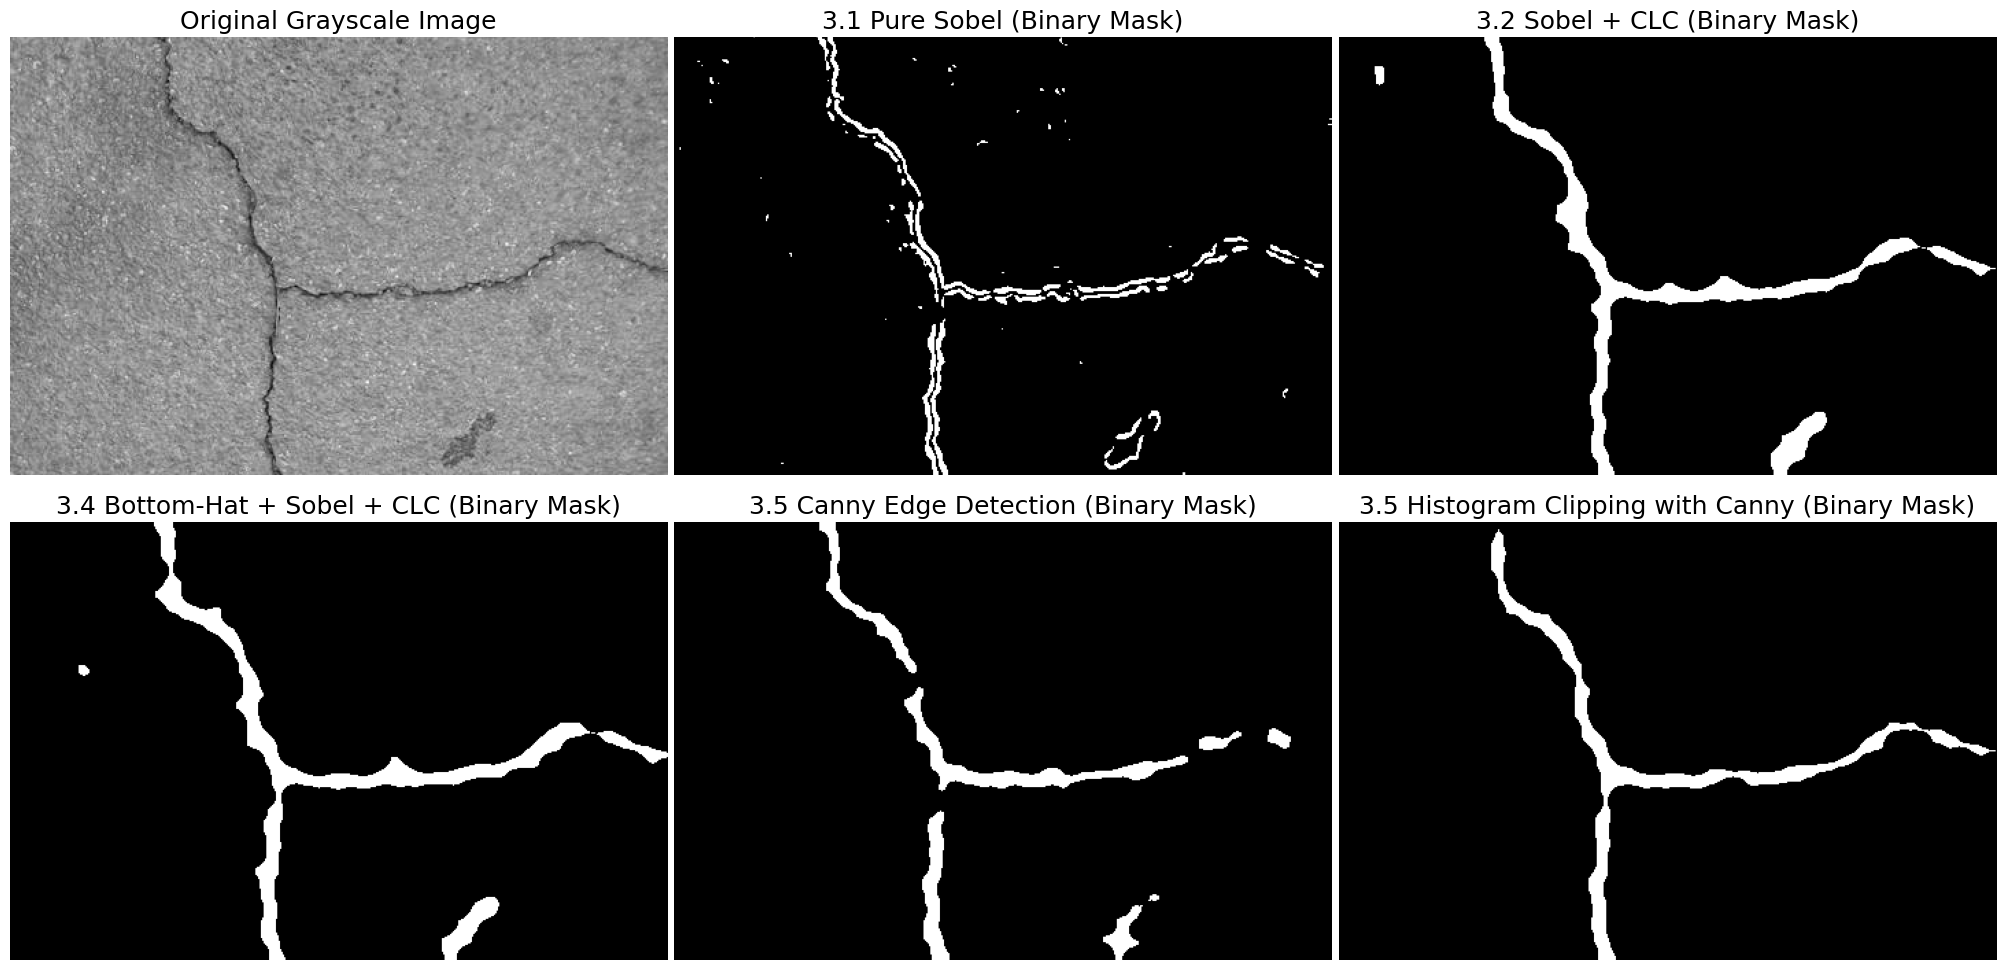

In [117]:
grid_images(images, titles, 2, 3, bg_color=255, save_path="./output/method_comparison.png", figsize=(20, 10), title_fontsize=18)